# 데이터 준비
- 참고한 링크
: https://stackabuse.com/python-for-nlp-creating-multi-data-type-classification-models-with-keras/
- https://ebbnflow.tistory.com/154
- https://monetd.github.io/python/nlp/Word-Embedding-Word2Vec-%EC%8B%A4%EC%8A%B5/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

In [5]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.seed = 42
DATA_PATH = "/content/drive/MyDrive/임시/data_0116/"

warnings.filterwarnings(action='ignore')
PATH_2017 = DATA_PATH + "train/KNOW_2017.csv"
PATH_2018 = DATA_PATH + "train/KNOW_2018.csv"
PATH_2019 = DATA_PATH + "train/KNOW_2019.csv"
PATH_2020 = DATA_PATH + "train/KNOW_2020.csv"

paths = [PATH_2017, PATH_2018, PATH_2019, PATH_2020]
know_train = [pd.read_csv(path) for path in paths]

TEST_PATH_2017 = DATA_PATH + "test/KNOW_2017_test.csv"
TEST_PATH_2018 = DATA_PATH + "test/KNOW_2018_test.csv"
TEST_PATH_2019 = DATA_PATH + "test/KNOW_2019_test.csv"
TEST_PATH_2020 = DATA_PATH + "test/KNOW_2020_test.csv"

TEST_PATHs = [TEST_PATH_2017, TEST_PATH_2018, TEST_PATH_2019, TEST_PATH_2020]
know_test = [pd.read_csv(path) for path in TEST_PATHs]

# doc2vec을 사용할거라 txt열을 모두 하나로 모아줘야해요
text_info_cols = {"2017": ['sim_job','bef_job','able_job','major'],
                  "2018": ['sim_job','bef_job','able_job','major'],
                  "2019": ['bef_job','able_job','major'],
                  "2020": ['major'],}
years = ['2017','2018','2019','2020']

for i, year in enumerate(years):
    text_info_col = text_info_cols[year]
    for col in text_info_col:
        know_train[i]['text_response'] = know_train[i]['text_response'] + ' ' + know_train[i][col]
        know_test[i]['text_response'] = know_test[i]['text_response'] + ' ' + know_test[i][col]
    know_train[i].drop(text_info_col,axis=1, inplace=True)
    know_test[i].drop(text_info_col,axis=1, inplace=True)

# text_response 내 존재하는 stopwords들을 제거해줍시다
stopwords = ['없다','없음','0','모름','공란']
for i in tqdm(range(4)):
    for k, doc in enumerate(know_train[i]['text_response']):
        doc_list = doc.split(' ')
        new_list = [word for word in doc_list if word not in stopwords]
        new_string = ''
        for word in new_list:
            new_string += word
            new_string += ' '
        know_train[i].loc[k,'text_response'] = new_string[:-1]
    for k, doc in enumerate(know_test[i]['text_response']):
        doc_list = doc.split(' ')
        new_list = [word for word in doc_list if word not in stopwords]
        new_string = ''
        for word in new_list:
            new_string += word
            new_string += ' '
        know_test[i].loc[k,'text_response'] = new_string[:-1]

# description은 드랍합시다
for i in range(4):
    know_train[i].drop('description',axis=1,inplace=True)

100%|██████████| 4/4 [00:37<00:00,  9.28s/it]


# 몇 연도로 돌릴건지 정해줍시다

In [6]:
# 일단은 2017년으로 해봅시다

data = know_train[0]

from sklearn import preprocessing

# 딥러닝 모델에 돌리려면 target 값을 label encoding을 해주어야 합니다. 

X = data.drop(['idx','knowcode'],axis=1)

y = data['knowcode']

label_encoder = preprocessing.LabelEncoder()

y = label_encoder.fit_transform(y)


# train이랑 validation set을 나눠서 해보죠

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

# 이 부분은 반드시 해줘야 합니다! 마지막 softmax에서 다중분류로 인식하기 위해서 필요해요
len_output = len(np.unique(y_train))

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

# 변수 나누기 및 word embedding

In [7]:
# X1 변수에 대해서 정수로 매칭해줍니다(Text)

X1_train = []
sentences = list(X_train["text_response"])
for sen in sentences:
    X1_train.append(sen)
X1_val = []
sentences = list(X_val["text_response"])
for sen in sentences:
    X1_val.append(sen)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_val = tokenizer.texts_to_sequences(X1_val)

vocab_size = len(tokenizer.word_index) + 1

max_len_lst = [len(X1_train[i]) for i in range(len(X1_train))]
maxlen = np.max(max_len_lst)

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_val = pad_sequences(X1_val, padding='post', maxlen=maxlen)

print('X1_train의 shape :', X1_train.shape ,'(칼럼은',maxlen,'으로 이따가 input1으로 들어가야 하므로 기억해둡시다)')
print('X1_test의 shape :',X1_val.shape)

X1_train의 shape : (7588, 41) (칼럼은 41 으로 이따가 input1으로 들어가야 하므로 기억해둡시다)
X1_test의 shape : (1898, 41)


# 1) Pretrained Embedding Vector_ 어떤 분의 github를 가져옴

In [ ]:
# Pretrained 모델을 활용하여 embedding_matrix를 만들어줍니다
# https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view 에서 Word2Vec Pretrained Model을 다운로드 받아야합니다
# 게시판에 있었던 infersent모델은 pretrained model로서 이 부분만 바꿔주면 똑같아요!(임베딩 matrix를 만드는 한 방법!)

import gensim
Word2Vec = gensim.models.Word2Vec.load('/content/drive/MyDrive/임시/word2vec/ko.bin')
 
print(Word2Vec.wv.vectors.shape) # (30185, 200) --> 너무 적은데?
 
embedding_matrix = np.zeros((vocab_size, 200))
# 단어 집합 크기의 행과 200개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.

print(np.shape(embedding_matrix)) # (vocab_size, 200)

def get_vector(word):
    if word in Word2Vec:
        return Word2Vec[word]
    else:
        return None

for word, i in tokenizer.word_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 200개의 값(value)를 임시 변수에 저장
    if temp is not None: # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.
print('embedding_matrix의 shape : ',embedding_matrix.shape)

(30185, 200)
(14648, 200)
embedding_matrix의 shape :  (14648, 200)


In [ ]:
# X2 변수에 대해서 행렬로 바꿔줍니다(Numeric)

X2_train = X_train[X_train.columns.difference(['text_response'])].values
X2_val = X_val[X_val.columns.difference(['text_response'])].values

num_col_len = X2_train.shape[1]
print('X2 변수의 train shape :',X2_train.shape,'(칼럼은',num_col_len,'으로 이따가 input2으로 들어가야 하므로 기억해둡시다)')
print('X2 변수의 test shape :',X2_val.shape)

In [ ]:
# 0인벡터가 너무 많아
tmp = pd.DataFrame(embedding_matrix)
tmp_sum = tmp.sum(axis=1)
tmp_sum[tmp_sum==0]

0        0.0
18       0.0
35       0.0
51       0.0
54       0.0
        ... 
14642    0.0
14643    0.0
14644    0.0
14645    0.0
14647    0.0
Length: 10177, dtype: float64

# 2) Pretrained Embedding Vector _ fasttext로 wiki의 단어들로 학습함

In [ ]:
import gensim
ko_vec_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/임시/word2vec/wiki.ko.vec')

In [ ]:
from gensim.models.word2vec import Word2Vec
our_texts = [doc.split(' ') for doc in know_train[0]['text_response']]

our_model = Word2Vec(size=300, min_count=1)
our_model.build_vocab(our_texts)
total_examples = our_model.corpus_count
our_model.build_vocab([list(ko_vec_model.vocab.keys())], update=True)

In [ ]:
our_model.intersect_word2vec_format("/content/drive/MyDrive/임시/word2vec/wiki.ko.vec",binary=False)

In [ ]:
our_model.train(our_texts, total_examples=total_examples, epochs=our_model.iter)

(504045, 504045)

In [ ]:
print(our_model.wv.vectors.shape) # (879129, 300) --> 충분
 
embedding_matrix = np.zeros((vocab_size, 300))
# 단어 집합 크기의 행과 200개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.

print(np.shape(embedding_matrix)) # (vocab_size, 300)

def get_vector(word):
    if word in our_model:
        return our_model[word]
    else:
        return None

for word, i in tokenizer.word_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None: # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.
print('embedding_matrix의 shape : ',embedding_matrix.shape)

(887924, 300)
(14648, 300)
embedding_matrix의 shape :  (14648, 300)


In [ ]:
# 0인벡터가 너무 많아
tmp = pd.DataFrame(embedding_matrix)
tmp_sum = tmp.sum(axis=1)
tmp_sum[tmp_sum==0]

0        0.0
1269     0.0
1704     0.0
2273     0.0
2349     0.0
        ... 
14545    0.0
14546    0.0
14577    0.0
14613    0.0
14643    0.0
Length: 443, dtype: float64

In [ ]:
import pickle
with open('embedding_matrix_{}.pickle'.format('2017'), 'wb') as f:
    pickle.dump(embedding_matrix, f)

# 3) 우리 text로 훈련해서 사용하기 (word2vec)

In [ ]:
from gensim.models.word2vec import Word2Vec

our_texts = [doc.split(' ') for doc in know_train[0]['text_response']]
our_model = Word2Vec(our_texts, size=300, window=5, min_count=0, workers=4) # (17211, 200) --> min_count=0이라 한 번이라도 등장한 단어도 훈련에 포함되어 성능이 떨어질 수 있음
print(our_model.wv.vectors.shape) 
 
embedding_matrix = np.zeros((vocab_size, 300))
# 단어 집합 크기의 행과 200개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.

print(np.shape(embedding_matrix)) # (vocab_size, 200)

def get_vector(word):
    if word in our_model:
        return our_model[word]
    else:
        return None

for word, i in tokenizer.word_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 200개의 값(value)를 임시 변수에 저장
    if temp is not None: # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.
print('embedding_matrix의 shape : ',embedding_matrix.shape)

(17211, 300)
(14648, 300)
embedding_matrix의 shape :  (14648, 300)


In [ ]:
# 0인벡터가 너무 많아
tmp = pd.DataFrame(embedding_matrix)
tmp_sum = tmp.sum(axis=1)
tmp_sum[tmp_sum==0]

0        0.0
313      0.0
596      0.0
1269     0.0
1332     0.0
        ... 
14546    0.0
14577    0.0
14586    0.0
14613    0.0
14643    0.0
Length: 673, dtype: float64

# 4) embedding matrix 불러오기

In [9]:
# 데이터 로드
import pickle
with open('/content/drive/MyDrive/임시/word2vec/embedding_matrix_{}.pickle'.format('2017'), 'rb') as f:
    embedding_matrix = pickle.load(f)

In [39]:
embedding_matrix.shape

(14648, 300)

In [18]:
# 0인벡터가 너무 많아
tmp = pd.DataFrame(embedding_matrix)
tmp_sum = tmp.sum(axis=1)
tmp_sum[tmp_sum==0]

0        0.0
1269     0.0
1704     0.0
2273     0.0
2349     0.0
        ... 
14545    0.0
14546    0.0
14577    0.0
14613    0.0
14643    0.0
Length: 443, dtype: float64

# 모델 쌓기

In [13]:
# X2 변수에 대해서 행렬로 바꿔줍니다(Numeric)

X2_train = X_train[X_train.columns.difference(['text_response'])].values
X2_val = X_val[X_val.columns.difference(['text_response'])].values

num_col_len = X2_train.shape[1]
print('X2 변수의 train shape :',X2_train.shape,'(칼럼은',num_col_len,'으로 이따가 input2으로 들어가야 하므로 기억해둡시다)')
print('X2 변수의 test shape :',X2_val.shape)

X2 변수의 train shape : (7588, 147) (칼럼은 147 으로 이따가 input2으로 들어가야 하므로 기억해둡시다)
X2 변수의 test shape : (1898, 147)


In [14]:
import tensorflow as tf
tf.random.set_seed(RANDOM_STATE)

# GPU를 사용해서 학습해봐요
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [15]:
# 두가지 input을 받는 모델입니다
input_1 = Input(shape=(maxlen,))    # X1 변수가 이리로 들어가야 합니다. 때문에 칼럼을 maxlen으로 맞춰줍니다

input_2 = Input(shape=(num_col_len,)) # X2 변수가 이리로 들어가야 합니다. 때문에 칼럼을 num_col_len 맞춰줍니다

In [42]:
from keras.layers import Convolution1D, MaxPooling1D, AveragePooling1D, SeparableConv1D
from keras.layers import BatchNormalization

#### Text Dense(Left)
embedding_left = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(input_1)

Convolution1D_left_1 = SeparableConv1D(1024, 3, padding='same', strides=1)(embedding_left)
Batch_left_1 = BatchNormalization()(Convolution1D_left_1)

AveragePooling1D_left_1 = AveragePooling1D(pool_size=2)(Batch_left_1)
Batch_left_2 = BatchNormalization()(AveragePooling1D_left_1)

DropOut_left_1 = Dropout(0.5)(Batch_left_2)

Convolution1D_left_2 = SeparableConv1D(800, 3, padding='same', strides=1)(embedding_left)
Batch_left_3 = BatchNormalization()(Convolution1D_left_2)

AveragePooling1D_left_2 = AveragePooling1D(pool_size=2)(Batch_left_3)
Batch_left_4 = BatchNormalization()(AveragePooling1D_left_2)

DropOut_left_2 = Dropout(0.5)(Batch_left_4)

LSTM_left_1 = LSTM(512)(DropOut_left_2)
Batch_left_5 = BatchNormalization()(LSTM_left_1)


#### Numeric Dense(Right)
dense_right_1 = Dense(1024, activation='relu')(input_2)
Batch_right_1 = BatchNormalization()(dense_right_1)

DropOut_right_1 = Dropout(0.5)(Batch_right_1)

dense_right_2 = Dense(800, activation='relu')(DropOut_right_1)
Batch_right_2 = BatchNormalization()(dense_right_2)

DropOut_right_2 = Dropout(0.5)(Batch_right_2)

dense_right_3 = Dense(512, activation='relu')(DropOut_right_2)
Batch_right_3 = BatchNormalization()(dense_right_3)


#### Concat layer
concat_layer = Concatenate()([Batch_left_5, Batch_right_3])
output = Dense(len_output, activation='softmax')(concat_layer)

# model 만들기

with tf.device('/device:GPU:0'):
    model = Model(inputs=[input_1, input_2], outputs=output)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
    history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=200, verbose=1, validation_split=0.2)
    print(model.summary())

Epoch 1/200
48/48 [==============================] - 5s 42ms/step - loss: 6.7334 - acc: 0.0023 - val_loss: 6.3752 - val_acc: 0.0178
Epoch 2/200
48/48 [==============================] - 1s 30ms/step - loss: 6.4008 - acc: 0.0161 - val_loss: 6.1776 - val_acc: 0.0204
Epoch 3/200
48/48 [==============================] - 1s 30ms/step - loss: 5.9178 - acc: 0.0451 - val_loss: 6.0593 - val_acc: 0.0264
Epoch 4/200
48/48 [==============================] - 1s 31ms/step - loss: 5.4234 - acc: 0.0657 - val_loss: 5.9759 - val_acc: 0.0369
Epoch 5/200
48/48 [==============================] - 1s 31ms/step - loss: 5.0315 - acc: 0.0886 - val_loss: 5.9089 - val_acc: 0.0369
Epoch 6/200
48/48 [==============================] - 1s 30ms/step - loss: 4.6576 - acc: 0.1185 - val_loss: 5.8338 - val_acc: 0.0369
Epoch 7/200
48/48 [==============================] - 1s 31ms/step - loss: 4.3649 - acc: 0.1442 - val_loss: 5.6997 - val_acc: 0.0356
Epoch 8/200
48/48 [==============================] - 1s 31ms/step - loss: 4.

KeyboardInterrupt: ignored

In [38]:
from keras.layers import Convolution1D, MaxPooling1D, AveragePooling1D, SeparableConv1D
from keras.layers import BatchNormalization

#### Text Dense(Left)
embedding_left = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(input_1)

Convolution1D_left_1 = Convolution1D(1024, 3, padding='same', strides=1)(embedding_left)
Batch_left_1 = BatchNormalization()(Convolution1D_left_1)

AveragePooling1D_left_1 = AveragePooling1D(pool_size=2)(Batch_left_1)
Batch_left_2 = BatchNormalization()(AveragePooling1D_left_1)

DropOut_left_1 = Dropout(0.5)(Batch_left_2)

Convolution1D_left_2 = Convolution1D(800, 3, padding='same', strides=1)(embedding_left)
Batch_left_3 = BatchNormalization()(Convolution1D_left_2)

AveragePooling1D_left_2 = AveragePooling1D(pool_size=2)(Batch_left_3)
Batch_left_4 = BatchNormalization()(AveragePooling1D_left_2)

DropOut_left_2 = Dropout(0.5)(Batch_left_4)

LSTM_left_1 = LSTM(512)(DropOut_left_2)
Batch_left_5 = BatchNormalization()(LSTM_left_1)


#### Numeric Dense(Right)

input_2.reshape(,)

Convolution1D_right_1 = Convolution1D(1024, 2, padding='same', strides=1)(input_2)
Batch_right_1 = BatchNormalization()(Convolution1D_right_1)

AveragePooling1D_right_1 = AveragePooling1D(pool_size=2)(Batch_right_1)
Batch_right_2 = BatchNormalization()(AveragePooling1D_right_1)

dense_right_1 = Dense(1024, activation='relu')(Batch_right_2)
Batch_right_3 = BatchNormalization()(dense_right_1)

DropOut_right_1 = Dropout(0.5)(Batch_right_3)

dense_right_2 = Dense(800, activation='relu')(DropOut_right_1)
Batch_right_4 = BatchNormalization()(dense_right_2)

DropOut_right_2 = Dropout(0.5)(Batch_right_4)

dense_right_3 = Dense(512, activation='relu')(DropOut_right_2)
Batch_right_5 = BatchNormalization()(dense_right_3)


#### Concat layer
concat_layer = Concatenate()([Batch_left_5, Batch_right_5])
output = Dense(len_output, activation='softmax')(concat_layer)

# model 만들기

with tf.device('/device:GPU:0'):
    model = Model(inputs=[input_1, input_2], outputs=output)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
    history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=200, verbose=1, validation_split=0.2)
    print(model.summary())

ValueError: ignored

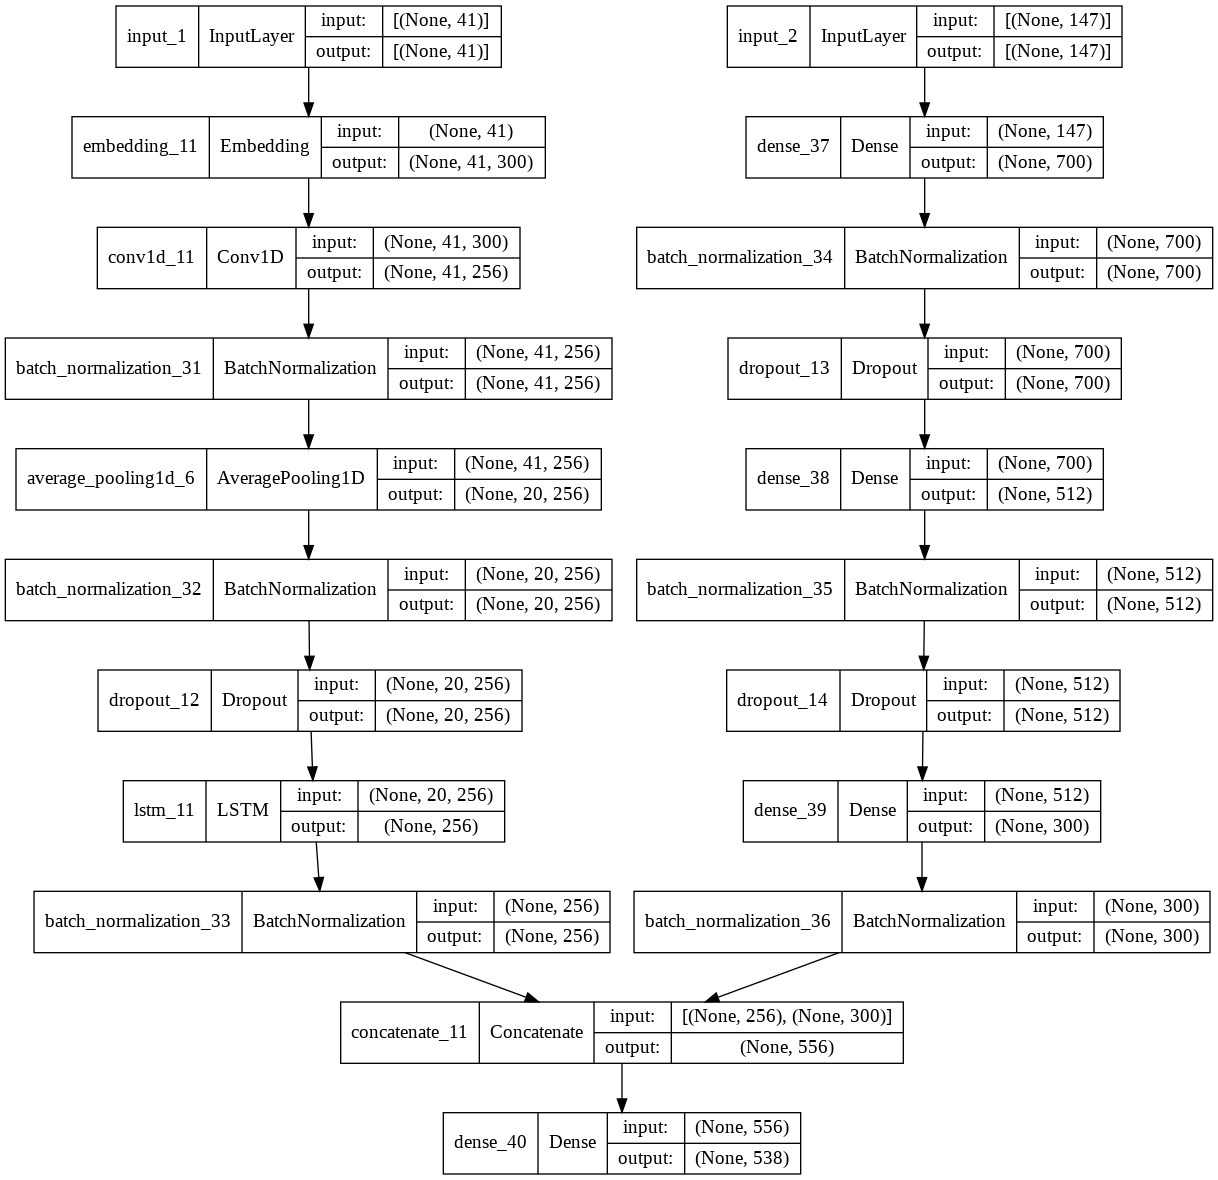

In [33]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

# 평가하기

In [ ]:
score = model.evaluate(x=[X1_val, X2_val], y=y_val, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

60/60 [==============================] - 0s 6ms/step - loss: 33.3641 - acc: 0.0948
Test Score: 33.36412048339844
Test Accuracy: 0.09483666718006134


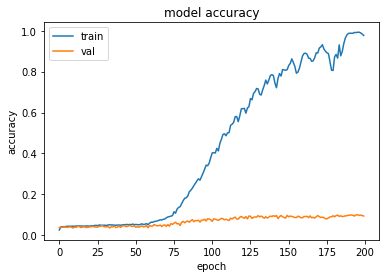

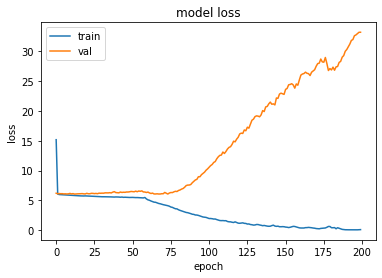

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# 예측하기

In [ ]:
proba_matrix = model.predict([X1_val, X2_val], verbose=1)
preds_encodered = np.argmax(proba_matrix, axis=1)

60/60 [==============================] - 1s 6ms/step


In [ ]:
classes_dict = {}
for i, label in enumerate(label_encoder.classes_):
    classes_dict[i] = label

preds = []  # preds에 knowcode 예측값이 담깁니다
for pred in preds_encodered:
    preds.append(classes_dict[pred])